Her er jeres første rigtige opgave! I skal lave bruge [yfinance](https://mercantec.notion.site/yfinance-8f05decbf9a040659da38616e432ed62?pvs=4) også kaldet Yahoo Finance, til at trække data ned på jeres yndlingsaktie! I skal herfra lave en regressionsmodel på dataet. Det involvere at splitte dataet op i træningsdata og testdata. 
Nedenunder er der lige et code-snippet til at få jer startet!

Vi skal bruge følgende pakker til at starte vores projekt, en del af dem kender I. Pandas fra første dag, datetime har i nok arbejdet med lignende pakker før. [yfinance](https://mercantec.notion.site/yfinance-8f05decbf9a040659da38616e432ed62?pvs=4) er den som er linket til ovenfor og har alt det data vi skal bruge. Til sidste er der matplitlib, den er ikke strengt nødvendig for vores projekt, men det hjælper ofte at få et visuelt billede på! Dokumentation kan findes [her](https://mercantec.notion.site/MatPlotLib-bb10bec44c8e4bc28ac511017dbc895d?pvs=4)

In [1]:
# import yfinance as yf
# import pandas as pd
# from datetime import date, timedelta
# from matplotlib import pyplot as plt

Vi bruger datetime pakken til at sætte et startspunkt og et slutpunkt. Startspunktet er for 365 dage siden og slutpunktet er for 2 dage siden!

In [2]:
# Start = date.today() - timedelta(365)
# Start.strftime('%Y-%m-%d')

# End = date.today() + timedelta(2)
# End.strftime('%Y-%m-%d')

'2024-01-12'

Vi laver en funktion som tager en "ticker" ind, altså en aktie. 
Her bruger vi så Pandas, pd, til at en dataframe som indeholder vores data omkring den valgte ticker, med slut og startsdato som definere før.

In [4]:
# def closing_price(ticker):
#     Asset = pd.DataFrame(yf.download(ticker, start=Start,
#       end=End))     
#     return Asset

Nu kan vi bruge vores funktion til at se på vores data. Her bruger vi Microsoft aktien, MSFT. Standarten er at vi for dato, åbningsprisen, højeste og laveste på dagen, lukke prisen og den justerede lukkepris. Vi kan så bruge matplotlib

[*********************100%%**********************]  1 of 1 completed


c:\Users\shiom\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


                Open      High       Low     Close    Volume
Date                                                        
2023-01-10  0.070210  0.051327  0.044497  0.044590  0.338949
2023-01-11  0.021589  0.015929  0.005860  0.006525  0.349097
2023-01-12  0.010341  0.000000  0.000000  0.013776  0.193407
2023-01-13  0.015240  0.037522  0.026918  0.055284  0.225601
2023-01-16  0.065675  0.066549  0.081487  0.084466  0.108921
                Open      High       Low     Close    Volume
Date                                                        
2023-10-25  0.828737  0.835752  0.850211  0.867682  0.113635
2023-10-26  0.838171  0.795752  0.796008  0.810042  0.134056
2023-10-27  0.757983  0.757168  0.758652  0.750952  0.184699
2023-10-30  0.759071  0.799646  0.784655  0.814392  0.123597
2023-10-31  0.828737  0.807788  0.827870  0.811854  0.133672
training dataset count:
Open      198
High      198
Low       198
Close     198
Volume    198
dtype: int64 

test dataset count:
Open      50
High

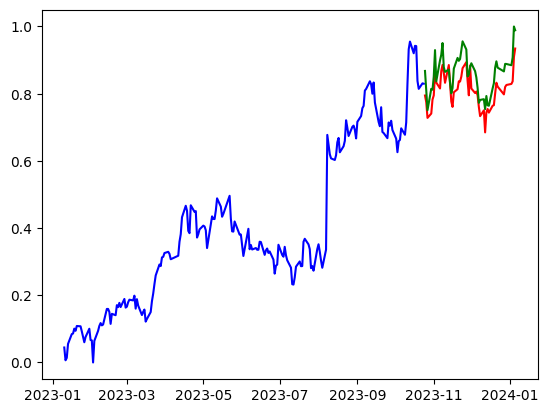

In [26]:
# microsoft = closing_price('MSFT') 
# print(microsoft)
# plt.plot(microsoft['Adj Close'])
# plt.show()

# Define Imports
import yfinance as yf
import pandas as pd
from datetime import date, timedelta
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=3, suppress=True)

# we select 1 year back 365
Start = date.today() - timedelta(365) 
# we select 4 years back 365 * 4 = 1460
# Start = date.today() - timedelta(1460) 
Start.strftime('%Y-%m-%d')

# we end 2 days before current day
End = date.today() - timedelta(2)
End.strftime('%Y-%m-%d')

# Define Functions here
def closing_price(ticker):
    Asset = pd.DataFrame(yf.download(ticker, start=Start,
      end=End))
    return Asset

def build_and_compile_model(input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(units=64,
                                return_sequences=True,
                                input_shape=input_shape))
    model.add(keras.layers.LSTM(units=64))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

    return model
from sklearn.preprocessing import MinMaxScaler

# Define which stock price we want data for
stockData = closing_price('NOVO-B.CO')
stockData.drop(columns=['Adj Close'], inplace=True)
dataset = stockData.copy()
dataset = dataset.dropna()

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data = pd.DataFrame(scaled_data, index=dataset.index, columns=dataset.columns)

train_dataset, test_dataset = np.split(scaled_data, [int(.8*len(scaled_data))])

# These provide human readable stats on the chosen stock
print(train_dataset.head())
print(test_dataset.head())
print("training dataset count:")
print(train_dataset.count(), '\n')
print("test dataset count:")
print(test_dataset.count())
train_dataset.describe().transpose()

train_features = train_dataset.copy().astype('float32')
test_features = test_dataset.copy().astype('float32')

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')
dnn_model = build_and_compile_model((train_features.shape[1],1))

dnn_model.fit(
    train_features,
    train_labels,
    validation_split=.02,
    epochs=100)
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

test_predictions = dnn_model.predict(test_features).flatten()
test_predictions = pd.Series(test_predictions, index=test_labels.index)

plt.figure(1)
plt.plot(train_labels, color="b")
plt.plot(test_predictions, color="r")

plt.plot(test_labels, color="g")
plt.show()




# Opgaven

Opgaven går nu på at I skal bruge jeres viden omkring regression på at lave en model som kan forudsige hvad aktie prisen bliver over den næste periode eller forhåbenligt bare en retning. 

Det er ikke målet at I skal finde en model som gør det, men at I skal lege rundt med det. De værktøjer som vi har fået indtil videre, er ikke nok til at kunne lave en model som har noget grundlag. Det data vi for er heller ikke nok. 

I kan tage inspiration ud fra dokumenterne her [regression](https://github.com/MAGS-Template/MachineLearning/blob/main/1.%20Regression/1.%20regression.ipynb) og [regression med data](https://github.com/MAGS-Template/MachineLearning/blob/main/1.%20Regression/2.%20regression_with_data.ipynb) - det er filerne i samme mappe som den her!
